In [1]:
# Import dependencies and APIs
# QUESTION: What influences a state's ability to control Covid-19?

import pandas as pd
import numpy as np
import requests
import json
from census import Census
from us import states
import matplotlib.pyplot as plt
import scipy.stats as st
import geoplot as gplt
import geopandas as gpd
import geoplot.crs as gcrs

from config import covidkey
from config import censuskey
from config import gkey
c = Census(censuskey, year=2013)
censuskey


'04f514dfbd7422da53425fd0190e7284a2214b9d'

In [2]:
# access census api
census_url=f"api.census.gov/data/2019/pep/population?get=COUNTY,DATE_CODE,DATE_DESC,DENSITY,POP,NAME,STATE&for=region:*&key={censuskey}"

census_url

'api.census.gov/data/2019/pep/population?get=COUNTY,DATE_CODE,DATE_DESC,DENSITY,POP,NAME,STATE&for=region:*&key=04f514dfbd7422da53425fd0190e7284a2214b9d'

In [3]:
# access covid now api
# https://api.covidactnow.org/v2/cbsas.timeseries.csv?apiKey={04f514dfbd7422da53425fd0190e7284a2214b9d}
covid_url = f"https://api.covidactnow.org/v2/states.timeseries.json?apiKey={covidkey}"
covid_url2 = f"https://api.covidactnow.org/v2/states.timeseries.csv?apiKey={covidkey}"
covid_url2

'https://api.covidactnow.org/v2/states.timeseries.csv?apiKey=72b8f0e0bd344e619f281fe9036fff5c'

In [4]:
# import covid state historical data
covid_historic = requests.get(covid_url).json()

In [5]:
covid_historic2 = pd.read_csv("CSVs/states.timeseries.csv")
covid_historic2.head()

,date,country,state,county,fips,lat,long,locationId,actuals.cases,actuals.deaths,...,metrics.infectionRateCI90,metrics.icuHeadroomRatio,metrics.icuHeadroomDetails,metrics.icuCapacityRatio,riskLevels.overall,metrics.vaccinationsInitiatedRatio,metrics.vaccinationsCompletedRatio,actuals.newDeaths,actuals.vaccinesAdministered,riskLevels.caseDensity
0,2020-03-01,US,AK,NaN,2,NaN,NaN,iso1:us#iso2:us-ak,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
1,2020-03-02,US,AK,NaN,2,NaN,NaN,iso1:us#iso2:us-ak,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
2,2020-03-03,US,AK,NaN,2,NaN,NaN,iso1:us#iso2:us-ak,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
3,2020-03-04,US,AK,NaN,2,NaN,NaN,iso1:us#iso2:us-ak,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
4,2020-03-05,US,AK,NaN,2,NaN,NaN,iso1:us#iso2:us-ak,NaN,NaN,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0


In [6]:
covid_historic_df1 = covid_historic2.loc[:,['date', 'state', 'actuals.cases', 'actuals.deaths', 'actuals.newDeaths', 'actuals.newCases']]
covid_historic_df1 = covid_historic_df1.fillna(0)
covid_historic_df1.head()

,date,state,actuals.cases,actuals.deaths,actuals.newDeaths,actuals.newCases
0,2020-03-01,AK,0.0,0.0,0.0,0.0
1,2020-03-02,AK,0.0,0.0,0.0,0.0
2,2020-03-03,AK,0.0,0.0,0.0,0.0
3,2020-03-04,AK,0.0,0.0,0.0,0.0
4,2020-03-05,AK,0.0,0.0,0.0,0.0


In [7]:
# state = []
# cases = []
# deaths = []
# dates = []
# population = []
# for i in covid_historic:
#     cases.append(i['actuals']['cases'])
#     deaths.append(i['actuals']['deaths'])
#     state.append(i['state'])
#     population.append(i['population'])
#     dates.append(i['date'])
#     #dates.append(i['actualsTimeseries'][0]['date'])
#     #dates.append(i['annotations']['cases']['anomalies'][]['date'])
#     #print(i['annotations']['cases']['anomalies'])
#     #input()
# d = {'state': state, 'cases': cases, 'deaths': deaths, 'dates': dates}
# covid_historic_df = pd.DataFrame(data=d)
# covid_historic_df

In [8]:
#covid_historic

In [9]:
#Import CovidNow data
covidnow_st_df=pd.read_csv("CSVs/Covid_Now_CSVs/states.csv")

covidnow_st_df.head()

,fips,country,state,county,level,lat,locationId,long,population,metrics.testPositivityRatio,...,actuals.newCases,actuals.vaccinesDistributed,actuals.vaccinationsInitiated,actuals.vaccinationsCompleted,lastUpdatedDate,url,metrics.vaccinationsInitiatedRatio,metrics.vaccinationsCompletedRatio,actuals.newDeaths,actuals.vaccinesAdministered
0,2,US,AK,NaN,state,NaN,iso1:us#iso2:us-ak,NaN,731545,0.066,...,439,848165,372132,330406,2021-07-24,https://covidactnow.org/us/alaska-ak,0.509,0.452,2,690518
1,1,US,AL,NaN,state,NaN,iso1:us#iso2:us-al,NaN,4903185,0.155,...,1733,4979270,2041597,1663031,2021-07-24,https://covidactnow.org/us/alabama-al,0.416,0.339,4,3494892
2,5,US,AR,NaN,state,NaN,iso1:us#iso2:us-ar,NaN,3017804,0.102,...,1987,2937300,1352937,1077347,2021-07-24,https://covidactnow.org/us/arkansas-ar,0.448,0.357,6,2363840
3,4,US,AZ,NaN,state,NaN,iso1:us#iso2:us-az,NaN,7278717,0.106,...,1479,8399110,3798435,3259542,2021-07-24,https://covidactnow.org/us/arizona-az,0.522,0.448,7,7001414
4,6,US,CA,NaN,state,NaN,iso1:us#iso2:us-ca,NaN,39512223,0.046,...,8933,50392775,25192441,20594557,2021-07-24,https://covidactnow.org/us/california-ca,0.638,0.521,45,44467248


In [10]:
#Import County level information
# covidnow_cou_df = ('CSVs/Covid_Now_CSVs/counties.csv')

# covidnow_cou_df

In [11]:
#Import lockdown duration by state
lockdown_df=pd.read_csv("CSVs/LockdownDuration.csv")

lockdown_df.head()

,state,stay at home length
0,AL,26
1,AK,27
2,AZ,15
3,AR,0
4,CA,162


In [12]:
# Import Oxford Covid data
oxford_df=pd.read_csv("CSVs/OxCGRT_US_latest.csv")

oxford_df.head()

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1_School closing,C1_Flag,C1_Notes,C2_Workplace closing,...,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
0,United States,USA,NaN,NaN,NAT_GOV,20200101,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,United States,USA,NaN,NaN,NAT_GOV,20200102,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,United States,USA,NaN,NaN,NAT_GOV,20200103,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,United States,USA,NaN,NaN,NAT_GOV,20200104,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,United States,USA,NaN,NaN,NAT_GOV,20200105,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Import State Demographics CSV File From the CORGIS Dataset Project (Ryan Whitcomb, 2016)
population_df=pd.read_csv("CSVs/state_demographics.csv")
population_df['State Abbrev'] = ''
population_df.drop(labels=[0],axis=0,inplace=True)
population_df.head()

,State,Age.Percent 65 and Older,Age.Percent Under 18 Years,Age.Percent Under 5 Years,Education.Bachelor's Degree or Higher,Education.High School or Higher,Employment.Nonemployer Establishments,Employment.Private Non-farm Employment,Employment.Private Non-farm Employment Percent Change,Employment.Private Non-farm Establishments,...,Sales.Retail Sales,Sales.Retail Sales per Capita,Employment.Firms.American Indian-Owned,Employment.Firms.Asian-Owned,Employment.Firms.Black-Owned,Employment.Firms.Hispanic-Owned,Employment.Firms.Native Hawaiian and Other Pacific Islander-Owned,Employment.Firms.Total,Employment.Firms.Women-Owned,State Abbrev
1,Alabama,15.3,22.8,6.1,22.6,83.1,311578,1603100,1.1,97578,...,573448,12364,0.8,1.8,14.8,1.2,0.1,382350,28.1,
2,Alaska,9.4,25.3,7.4,27.5,91.6,52991,266627,3.3,20519,...,93033,13635,10.0,3.1,1.5,0.0,0.3,68728,25.9,
3,Arizona,15.9,24.1,6.4,26.9,85.7,420233,2173205,1.8,132762,...,867588,13637,1.9,3.3,2.0,10.7,0.0,491529,28.1,
4,Arkansas,15.7,23.8,6.5,20.1,83.7,191530,978094,0.0,64772,...,329742,11602,1.1,1.4,5.5,2.3,0.1,238994,24.5,
5,California,12.9,23.6,6.5,30.7,81.2,2983996,13401863,3.5,874243,...,4550322,12561,1.3,14.9,4.0,16.5,0.3,3425510,30.3,


In [14]:
# Find the state abbreviation for each state for merging
states_list = []
for x in population_df['State']:
    St_list = states.lookup(x).abbr
    states_list.append(St_list)
        
population_df['state'] = states_list
population_df.head()

,State,Age.Percent 65 and Older,Age.Percent Under 18 Years,Age.Percent Under 5 Years,Education.Bachelor's Degree or Higher,Education.High School or Higher,Employment.Nonemployer Establishments,Employment.Private Non-farm Employment,Employment.Private Non-farm Employment Percent Change,Employment.Private Non-farm Establishments,...,Sales.Retail Sales per Capita,Employment.Firms.American Indian-Owned,Employment.Firms.Asian-Owned,Employment.Firms.Black-Owned,Employment.Firms.Hispanic-Owned,Employment.Firms.Native Hawaiian and Other Pacific Islander-Owned,Employment.Firms.Total,Employment.Firms.Women-Owned,State Abbrev,state
1,Alabama,15.3,22.8,6.1,22.6,83.1,311578,1603100,1.1,97578,...,12364,0.8,1.8,14.8,1.2,0.1,382350,28.1,,AL
2,Alaska,9.4,25.3,7.4,27.5,91.6,52991,266627,3.3,20519,...,13635,10.0,3.1,1.5,0.0,0.3,68728,25.9,,AK
3,Arizona,15.9,24.1,6.4,26.9,85.7,420233,2173205,1.8,132762,...,13637,1.9,3.3,2.0,10.7,0.0,491529,28.1,,AZ
4,Arkansas,15.7,23.8,6.5,20.1,83.7,191530,978094,0.0,64772,...,11602,1.1,1.4,5.5,2.3,0.1,238994,24.5,,AR
5,California,12.9,23.6,6.5,30.7,81.2,2983996,13401863,3.5,874243,...,12561,1.3,14.9,4.0,16.5,0.3,3425510,30.3,,CA


In [15]:
# Filter DF for columns of interest
filtered_pop_df = population_df.loc[:,['state','State','Population.Population per Square Mile']]
filtered_pop_df.head()

,state,State,Population.Population per Square Mile
1,AL,Alabama,94.4
2,AK,Alaska,1.2
3,AZ,Arizona,56.3
4,AR,Arkansas,56.0
5,CA,California,239.1


In [16]:
# Merge DF's on state
merged_df = pd.merge(filtered_pop_df, covidnow_st_df, on="state")
merged_df.head()

,state,State,Population.Population per Square Mile,fips,country,county,level,lat,locationId,long,...,actuals.newCases,actuals.vaccinesDistributed,actuals.vaccinationsInitiated,actuals.vaccinationsCompleted,lastUpdatedDate,url,metrics.vaccinationsInitiatedRatio,metrics.vaccinationsCompletedRatio,actuals.newDeaths,actuals.vaccinesAdministered
0,AL,Alabama,94.4,1,US,NaN,state,NaN,iso1:us#iso2:us-al,NaN,...,1733,4979270,2041597,1663031,2021-07-24,https://covidactnow.org/us/alabama-al,0.416,0.339,4,3494892
1,AK,Alaska,1.2,2,US,NaN,state,NaN,iso1:us#iso2:us-ak,NaN,...,439,848165,372132,330406,2021-07-24,https://covidactnow.org/us/alaska-ak,0.509,0.452,2,690518
2,AZ,Arizona,56.3,4,US,NaN,state,NaN,iso1:us#iso2:us-az,NaN,...,1479,8399110,3798435,3259542,2021-07-24,https://covidactnow.org/us/arizona-az,0.522,0.448,7,7001414
3,AR,Arkansas,56.0,5,US,NaN,state,NaN,iso1:us#iso2:us-ar,NaN,...,1987,2937300,1352937,1077347,2021-07-24,https://covidactnow.org/us/arkansas-ar,0.448,0.357,6,2363840
4,CA,California,239.1,6,US,NaN,state,NaN,iso1:us#iso2:us-ca,NaN,...,8933,50392775,25192441,20594557,2021-07-24,https://covidactnow.org/us/california-ca,0.638,0.521,45,44467248


In [17]:
# Pull total state population from census api
census_data = c.acs5.get('B01003_001E', {'for': 'state:*'})
census_pd = pd.DataFrame(census_data)
census_pd = census_pd.rename(columns ={'B01003_001E': 'Population'})
census_pd.head()

,Population,state
0,4799277.0,01
1,720316.0,02
2,6479703.0,04
3,2933369.0,05
4,37659181.0,06


In [18]:
# Create an empty column for the state abbreviations
census_pd['State'] = " "

In [19]:
# Replace the state codes with abbreviations
states_list = []
for x in census_pd['state']:
    Z = states.lookup(x).abbr
    states_list.append(Z)

census_pd['State'] = states_list
census_pd.drop(labels=['state'],axis=1,inplace=True)
census_pd = census_pd.rename(columns ={'State': 'state'})
census_pd.head()

,Population,state
0,4799277.0,AL
1,720316.0,AK
2,6479703.0,AZ
3,2933369.0,AR
4,37659181.0,CA


In [20]:
# Merge population data onto the main df
final_df = pd.merge(census_pd,merged_df, on="state")
final_df.head()

,Population,state,State,Population.Population per Square Mile,fips,country,county,level,lat,locationId,...,actuals.newCases,actuals.vaccinesDistributed,actuals.vaccinationsInitiated,actuals.vaccinationsCompleted,lastUpdatedDate,url,metrics.vaccinationsInitiatedRatio,metrics.vaccinationsCompletedRatio,actuals.newDeaths,actuals.vaccinesAdministered
0,4799277.0,AL,Alabama,94.4,1,US,NaN,state,NaN,iso1:us#iso2:us-al,...,1733,4979270,2041597,1663031,2021-07-24,https://covidactnow.org/us/alabama-al,0.416,0.339,4,3494892
1,720316.0,AK,Alaska,1.2,2,US,NaN,state,NaN,iso1:us#iso2:us-ak,...,439,848165,372132,330406,2021-07-24,https://covidactnow.org/us/alaska-ak,0.509,0.452,2,690518
2,6479703.0,AZ,Arizona,56.3,4,US,NaN,state,NaN,iso1:us#iso2:us-az,...,1479,8399110,3798435,3259542,2021-07-24,https://covidactnow.org/us/arizona-az,0.522,0.448,7,7001414
3,2933369.0,AR,Arkansas,56.0,5,US,NaN,state,NaN,iso1:us#iso2:us-ar,...,1987,2937300,1352937,1077347,2021-07-24,https://covidactnow.org/us/arkansas-ar,0.448,0.357,6,2363840
4,37659181.0,CA,California,239.1,6,US,NaN,state,NaN,iso1:us#iso2:us-ca,...,8933,50392775,25192441,20594557,2021-07-24,https://covidactnow.org/us/california-ca,0.638,0.521,45,44467248


In [21]:
# Find the ratio of the total population for deaths and positive cases
final_df['Death Ratio'] = final_df['actuals.deaths']/final_df['Population']
final_df['Positive Ratio'] = final_df['actuals.positiveTests']/final_df['Population']
final_df.head()

,Population,state,State,Population.Population per Square Mile,fips,country,county,level,lat,locationId,...,actuals.vaccinationsInitiated,actuals.vaccinationsCompleted,lastUpdatedDate,url,metrics.vaccinationsInitiatedRatio,metrics.vaccinationsCompletedRatio,actuals.newDeaths,actuals.vaccinesAdministered,Death Ratio,Positive Ratio
0,4799277.0,AL,Alabama,94.4,1,US,NaN,state,NaN,iso1:us#iso2:us-al,...,2041597,1663031,2021-07-24,https://covidactnow.org/us/alabama-al,0.416,0.339,4,3494892,0.002390,0.116733
1,720316.0,AK,Alaska,1.2,2,US,NaN,state,NaN,iso1:us#iso2:us-ak,...,372132,330406,2021-07-24,https://covidactnow.org/us/alaska-ak,0.509,0.452,2,690518,0.000509,0.159061
2,6479703.0,AZ,Arizona,56.3,4,US,NaN,state,NaN,iso1:us#iso2:us-az,...,3798435,3259542,2021-07-24,https://covidactnow.org/us/arizona-az,0.522,0.448,7,7001414,0.002800,0.143022
3,2933369.0,AR,Arkansas,56.0,5,US,NaN,state,NaN,iso1:us#iso2:us-ar,...,1352937,1077347,2021-07-24,https://covidactnow.org/us/arkansas-ar,0.448,0.357,6,2363840,0.002059,0.084505
4,37659181.0,CA,California,239.1,6,US,NaN,state,NaN,iso1:us#iso2:us-ca,...,25192441,20594557,2021-07-24,https://covidactnow.org/us/california-ca,0.638,0.521,45,44467248,0.001705,0.102275


In [22]:
# Merge lockdown duration onto the main df
Covid_df = pd.merge(lockdown_df,final_df, on="state")
Covid_df.describe()

,stay at home length,Population,Population.Population per Square Mile,fips,county,lat,long,population,metrics.testPositivityRatio,metrics.caseDensity,...,actuals.newCases,actuals.vaccinesDistributed,actuals.vaccinationsInitiated,actuals.vaccinationsCompleted,metrics.vaccinationsInitiatedRatio,metrics.vaccinationsCompletedRatio,actuals.newDeaths,actuals.vaccinesAdministered,Death Ratio,Positive Ratio
count,51.000000,5.100000e+01,51.000000,51.000000,0.0,0.0,0.0,5.100000e+01,51.000000,51.000000,...,51.000000,5.100000e+01,5.100000e+01,5.100000e+01,51.000000,51.000000,51.000000,5.100000e+01,51.000000,51.000000
mean,42.529412,6.108561e+06,384.403922,28.960784,NaN,NaN,NaN,6.436069e+06,0.064980,13.443137,...,1618.549020,7.615015e+06,3.599701e+06,3.120356e+06,0.548490,0.481882,8.784314,6.554889e+06,0.001793,0.115916
std,29.785468,6.904016e+06,1377.354603,15.832828,NaN,NaN,NaN,7.360660e+06,0.044588,11.340269,...,4028.490836,9.082527e+06,4.412634e+06,3.696989e+06,0.093681,0.085247,22.138937,7.916861e+06,0.000629,0.035080
min,0.000000,5.701340e+05,1.200000,1.000000,NaN,NaN,NaN,5.787590e+05,0.014000,2.600000,...,0.000000,5.233050e+05,2.375800e+05,2.099380e+05,0.383000,0.339000,0.000000,4.416990e+05,0.000381,0.031796
25%,27.000000,1.712494e+06,45.800000,16.500000,NaN,NaN,NaN,1.789606e+06,0.028500,5.800000,...,212.500000,1.960818e+06,9.572660e+05,8.176495e+05,0.470500,0.419000,0.000000,1.680052e+06,0.001414,0.100409
50%,38.000000,4.361333e+06,101.200000,29.000000,NaN,NaN,NaN,4.467673e+06,0.051000,9.100000,...,624.000000,4.863135e+06,2.283310e+06,2.013778e+06,0.526000,0.480000,3.000000,4.131634e+06,0.001869,0.118090
75%,55.500000,6.712318e+06,221.450000,41.500000,NaN,NaN,NaN,7.446805e+06,0.091500,16.200000,...,1511.500000,9.793128e+06,4.799798e+06,4.189238e+06,0.632000,0.540500,7.000000,8.825498e+06,0.002141,0.138120
max,162.000000,3.765918e+07,9856.500000,56.000000,NaN,NaN,NaN,3.951222e+07,0.169000,48.700000,...,27514.000000,5.039278e+07,2.519244e+07,2.059456e+07,0.751000,0.672000,148.000000,4.446725e+07,0.003008,0.184001


The correlation between both factors is -0.06


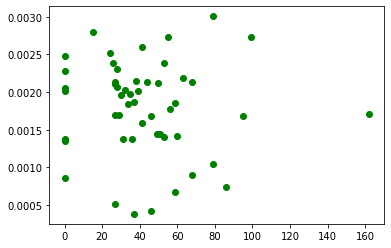

In [23]:

plt.scatter(Covid_df['stay at home length'],Covid_df['Death Ratio'],color='green')
correlation = st.pearsonr(Covid_df['stay at home length'],Covid_df['Death Ratio'])
print(f"The correlation between both factors is {round(correlation[0],2)}")
plt.show()

The correlation between both factors is -0.24


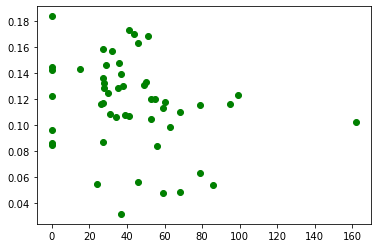

In [24]:

plt.scatter(Covid_df['stay at home length'],Covid_df['Positive Ratio'],color='green')
correlation = st.pearsonr(Covid_df['stay at home length'],Covid_df['Positive Ratio'])
print(f"The correlation between both factors is {round(correlation[0],2)}")
plt.show()

The correlation between both factors is -0.24


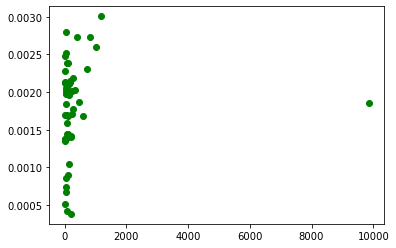

In [25]:

plt.scatter(Covid_df['Population.Population per Square Mile'],Covid_df['Death Ratio'],color='green')
correlation = st.pearsonr(Covid_df['stay at home length'],Covid_df['Positive Ratio'])
print(f"The correlation between both factors is {round(correlation[0],2)}")
plt.show()

The correlation between both factors is -0.24


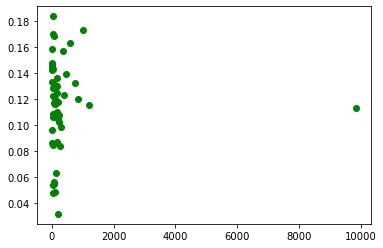

In [26]:

plt.scatter(Covid_df['Population.Population per Square Mile'],Covid_df['Positive Ratio'],color='green')
correlation = st.pearsonr(Covid_df['stay at home length'],Covid_df['Positive Ratio'])
print(f"The correlation between both factors is {round(correlation[0],2)}")
plt.show()

The correlation between both factors is -0.24


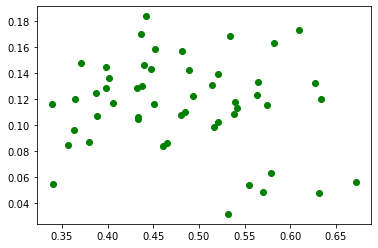

In [27]:

plt.scatter(Covid_df['metrics.vaccinationsCompletedRatio'],Covid_df['Positive Ratio'],color='green')
correlation = st.pearsonr(Covid_df['stay at home length'],Covid_df['Positive Ratio'])
print(f"The correlation between both factors is {round(correlation[0],2)}")
plt.show()

The correlation between both factors is -0.24


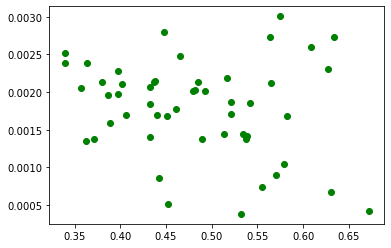

In [28]:

plt.scatter(Covid_df['metrics.vaccinationsCompletedRatio'],Covid_df['Death Ratio'],color='green')
correlation = st.pearsonr(Covid_df['stay at home length'],Covid_df['Positive Ratio'])
print(f"The correlation between both factors is {round(correlation[0],2)}")
plt.show()

In [29]:
#Create a new df which bins the states by population density for bar graphs
#Covid_df.describe()

bins = [0,25,50,75,100,150,250,350,10000]
group_names = ['0-24','25-49','50-74','75-99','100-149','150-249','250-349','350+']
Covid_df['PopDenBins'] = pd.cut(Covid_df['Population.Population per Square Mile'], bins, labels=group_names, include_lowest=True)
Covid_df['PopDenBins'].head()

0      75-99
1       0-24
2      50-74
3      50-74
4    150-249
Name: PopDenBins, dtype: category
Categories (8, object): ['0-24' < '25-49' < '50-74' < '75-99' < '100-149' < '150-249' < '250-349' < '350+']

In [30]:
PopDen_group = Covid_df.groupby('PopDenBins')
PopDen_group['Death Ratio'].mean()

PopDenBins
0-24       0.001702
25-49      0.001098
50-74      0.001889
75-99      0.001936
100-149    0.001493
150-249    0.001742
250-349    0.001979
350+       0.002313
Name: Death Ratio, dtype: float64

In [31]:
#create latitute and longitude values from google api for use in gmaps
derived_lats= [] 
derived_longs=[]
for stateValues in Covid_df['State']:
    target_url = f"https://maps.googleapis.com/maps/api/geocode/json?address={stateValues}&key={gkey}"
    geo_data = requests.get(target_url).json()
    derived_lats.append(geo_data["results"][0]["geometry"]["location"]["lat"])
    derived_longs.append(geo_data["results"][0]["geometry"]["location"]["lng"])

Covid_df['Latitude'] = derived_lats
Covid_df['Longitude'] = derived_longs

In [32]:
#find the Polygon coordinates for states from gplot library
path = gplt.datasets.get_path("contiguous_usa")
contiguous_usa = gpd.read_file(path)

In [33]:
contiguous_usa = contiguous_usa.rename(columns = {'state': 'State'})

In [34]:
derived_df = contiguous_usa.loc[:,['State','geometry']]

In [35]:
#mergeplot info with 
mergedGeo_df = pd.merge(derived_df, Covid_df, on="State")

In [56]:
#gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude))
CovidGeo = gpd.GeoDataFrame(mergedGeo_df, geometry=mergedGeo_df.geometry)
CovidGeo

,State,geometry,state,stay at home length,Population,Population.Population per Square Mile,fips,country,county,level,...,url,metrics.vaccinationsInitiatedRatio,metrics.vaccinationsCompletedRatio,actuals.newDeaths,actuals.vaccinesAdministered,Death Ratio,Positive Ratio,PopDenBins,Latitude,Longitude
0,Minnesota,"POLYGON ((-89.59941 48.01027, -89.48888 48.013...",MN,51,5347740.0,66.6,27,US,NaN,state,...,https://covidactnow.org/us/minnesota-mn,0.582,0.534,2,6022687,0.001448,0.168442,50-74,46.729553,-94.685900
1,Montana,"POLYGON ((-111.19419 44.56116, -111.29155 44.7...",MT,29,998554.0,6.8,30,US,NaN,state,...,https://covidactnow.org/us/montana-mt,0.488,0.440,0,963455,0.001697,0.146310,0-24,46.879682,-110.362566
2,North Dakota,"POLYGON ((-96.60136 46.35136, -96.53891 46.199...",ND,0,689781.0,9.7,38,US,NaN,state,...,https://covidactnow.org/us/north_dakota-nd,0.449,0.398,0,656264,0.002275,0.145227,0-24,47.551493,-101.002012
3,Idaho,"POLYGON ((-111.04973 44.48816, -111.05025 42.0...",ID,36,1583364.0,19.0,16,US,NaN,state,...,https://covidactnow.org/us/idaho-id,0.406,0.371,3,1359014,0.001380,0.147817,0-24,44.068202,-114.742041
4,Washington,"POLYGON ((-116.99807 46.33017, -116.90653 46.1...",WA,68,6819579.0,101.2,53,US,NaN,state,...,https://covidactnow.org/us/washington-wa,0.632,0.570,10,8902244,0.000898,0.048381,100-149,47.751074,-120.740139
5,Arizona,"POLYGON ((-109.04523 36.99991, -109.04367 31.3...",AZ,15,6479703.0,56.3,4,US,NaN,state,...,https://covidactnow.org/us/arizona-az,0.522,0.448,7,7001414,0.002800,0.143022,50-74,34.048928,-111.093731
6,California,"POLYGON ((-114.35490 34.46467, -114.16597 34.2...",CA,162,37659181.0,239.1,6,US,NaN,state,...,https://covidactnow.org/us/california-ca,0.638,0.521,45,44467248,0.001705,0.102275,150-249,36.778261,-119.417932
7,Colorado,"POLYGON ((-102.05017 40.00082, -102.04012 38.4...",CO,31,5119329.0,48.5,8,US,NaN,state,...,https://covidactnow.org/us/colorado-co,0.596,0.538,6,6397692,0.001379,0.108756,25-49,39.550051,-105.782067
8,Nevada,"POLYGON ((-114.03053 36.99410, -114.02363 36.1...",NV,44,2730066.0,24.6,32,US,NaN,state,...,https://covidactnow.org/us/nevada-nv,0.524,0.437,20,2908084,0.002131,0.170071,0-24,38.802610,-116.419389
9,New Mexico,"POLYGON ((-103.00161 33.87995, -103.00161 31.9...",NM,50,2069706.0,17.0,35,US,NaN,state,...,https://covidactnow.org/us/new_mexico-nm,0.646,0.565,3,2455789,0.002125,0.133681,0-24,34.519940,-105.870090


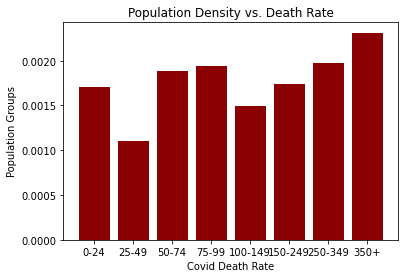

In [54]:
# Bar graph showing population density vs death rate
plt.bar(group_names, PopDen_group['Death Ratio'].mean(),color=("darkred"))
plt.title("Population Density vs. Death Rate")
plt.xlabel("Population Density Groups")
plt.ylabel("Covid Death Rate")
plt.show()

<GeoAxesSubplot:>

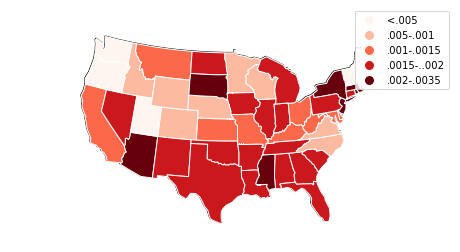

In [57]:
ax = gplt.polyplot(CovidGeo, projection=gcrs.AlbersEqualArea())
gplt.choropleth(
  CovidGeo,
  hue="Death Ratio",
  edgecolor="white",
  linewidth=1,
  cmap="Reds",
  legend=True,
  scheme="FisherJenks",
  legend_labels=[
    "<.005", ".005-.001", ".001-.0015",
    ".0015-..002",".002-.0035"
  ],
  projection=gcrs.AlbersEqualArea(),
  ax=ax
)

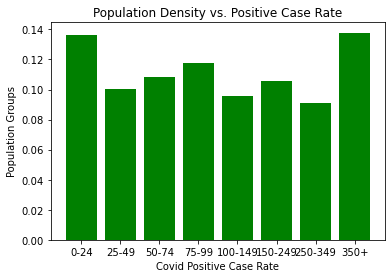

In [52]:
# Bar graph showing population density 
plt.bar(group_names, PopDen_group['Positive Ratio'].mean(),color=("green"))
plt.title("Population Density vs. Positive Case Rate")
plt.xlabel("Population Density Groups")
plt.ylabel("Positive Covid Case Rate")
plt.show()


<GeoAxesSubplot:>

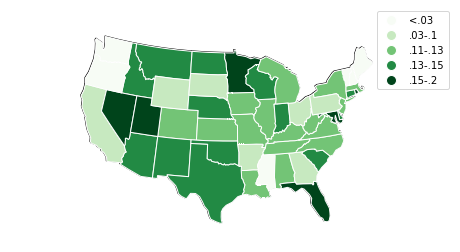

In [39]:
ax = gplt.polyplot(CovidGeo, projection=gcrs.AlbersEqualArea())
gplt.choropleth(
  CovidGeo,
  hue="Positive Ratio",
  edgecolor="white",
  linewidth=1,
  cmap="Greens",
  legend=True,
  scheme="FisherJenks",
  legend_labels=[
    "<.03", ".03-.1", ".11-.13",
    ".13-.15",".15-.2"
  ],
  projection=gcrs.AlbersEqualArea(),
  ax=ax
)

<BarContainer object of 8 artists>

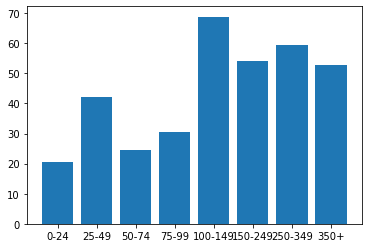

In [40]:
plt.bar(group_names, PopDen_group['stay at home length'].mean())

In [41]:
covid_historic_df = pd.merge(census_pd, covid_historic_df1, on='state')
covid_historic_df.head()

,Population,state,date,actuals.cases,actuals.deaths,actuals.newDeaths,actuals.newCases
0,4799277.0,AL,2020-03-01,0.0,0.0,0.0,0.0
1,4799277.0,AL,2020-03-02,0.0,0.0,0.0,0.0
2,4799277.0,AL,2020-03-03,0.0,0.0,0.0,0.0
3,4799277.0,AL,2020-03-04,0.0,0.0,0.0,0.0
4,4799277.0,AL,2020-03-05,0.0,0.0,0.0,0.0


In [42]:
covid_historic_df['%cases'] = covid_historic_df['actuals.cases']/covid_historic_df['Population']
covid_historic_df['%deaths'] = covid_historic_df['actuals.deaths']/covid_historic_df['Population']
covid_historic_df['%newCases'] = covid_historic_df['actuals.newCases']/covid_historic_df['Population']
covid_historic_df['%newDeaths'] = covid_historic_df['actuals.newDeaths']/covid_historic_df['Population']
covid_historic_df.head()

,Population,state,date,actuals.cases,actuals.deaths,actuals.newDeaths,actuals.newCases,%cases,%deaths,%newCases,%newDeaths
0,4799277.0,AL,2020-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4799277.0,AL,2020-03-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4799277.0,AL,2020-03-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4799277.0,AL,2020-03-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4799277.0,AL,2020-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
Alabama = covid_historic_df[covid_historic_df['state'] == 'AL']
Alaska = covid_historic_df[covid_historic_df['state'] == 'AK']
Arizona =  covid_historic_df[covid_historic_df['state'] == 'AZ']
Arkansas = covid_historic_df[covid_historic_df['state'] == 'AR']
California= covid_historic_df[covid_historic_df['state'] == 'CA']
Colorado= covid_historic_df[covid_historic_df['state'] == 'CO']
Connecticut= covid_historic_df[covid_historic_df['state'] == 'CT']
Delaware= covid_historic_df[covid_historic_df['state'] == 'DE']
Florida= covid_historic_df[covid_historic_df['state'] == 'FL']
Georgia= covid_historic_df[covid_historic_df['state'] == 'GA']
Hawaii= covid_historic_df[covid_historic_df['state'] == 'HI']
Idaho= covid_historic_df[covid_historic_df['state'] == 'ID']
Illinois= covid_historic_df[covid_historic_df['state'] == 'IL']
Indiana= covid_historic_df[covid_historic_df['state'] == 'IN']
Iowa= covid_historic_df[covid_historic_df['state'] == 'IA']
Kansas= covid_historic_df[covid_historic_df['state'] == 'KS']
Kentucky= covid_historic_df[covid_historic_df['state'] == 'KY']
Louisiana= covid_historic_df[covid_historic_df['state'] == 'LA']
Maine= covid_historic_df[covid_historic_df['state'] == 'ME']
Maryland= covid_historic_df[covid_historic_df['state'] == 'MD']
Massachusetts= covid_historic_df[covid_historic_df['state'] == 'MA']
Michigan= covid_historic_df[covid_historic_df['state'] == 'MI']
Minnesota= covid_historic_df[covid_historic_df['state'] == 'MN']
Mississippi= covid_historic_df[covid_historic_df['state'] == 'MS']
Missouri= covid_historic_df[covid_historic_df['state'] == 'MO']
Montana= covid_historic_df[covid_historic_df['state'] == 'MT']
Nebraska= covid_historic_df[covid_historic_df['state'] == 'NE']
Nevada= covid_historic_df[covid_historic_df['state'] == 'NV']
NewHampshire= covid_historic_df[covid_historic_df['state'] == 'NH']
NewJersey= covid_historic_df[covid_historic_df['state'] == 'NJ']
NewMexico= covid_historic_df[covid_historic_df['state'] == 'NM']
NewYork= covid_historic_df[covid_historic_df['state'] == 'NY']
NorthCarolina= covid_historic_df[covid_historic_df['state'] == 'NC']
NorthDakota= covid_historic_df[covid_historic_df['state'] == 'ND']
Ohio= covid_historic_df[covid_historic_df['state'] == 'OH']
Oklahoma= covid_historic_df[covid_historic_df['state'] == 'OK']
Oregon= covid_historic_df[covid_historic_df['state'] == 'OR']
Pennsylvania= covid_historic_df[covid_historic_df['state'] == 'PA']
RhodeIsland= covid_historic_df[covid_historic_df['state'] == 'RI']
SouthCarolina= covid_historic_df[covid_historic_df['state'] == 'SC']
SouthDakota= covid_historic_df[covid_historic_df['state'] == 'SD']
Tennessee= covid_historic_df[covid_historic_df['state'] == 'TN']
Texas= covid_historic_df[covid_historic_df['state'] == 'TX']
Utah= covid_historic_df[covid_historic_df['state'] == 'UT']
Vermont= covid_historic_df[covid_historic_df['state'] == 'VT']
Virginia= covid_historic_df[covid_historic_df['state'] == 'VA']
Washington= covid_historic_df[covid_historic_df['state'] == 'WA']
WestVirginia= covid_historic_df[covid_historic_df['state'] == 'WV']
Wisconsin= covid_historic_df[covid_historic_df['state'] == 'WI']
Wyoming= covid_historic_df[covid_historic_df['state'] == 'WY']
Wyoming.head()

,Population,state,date,actuals.cases,actuals.deaths,actuals.newDeaths,actuals.newCases,%cases,%deaths,%newCases,%newDeaths
26200,570134.0,WY,2020-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26201,570134.0,WY,2020-03-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26202,570134.0,WY,2020-03-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26203,570134.0,WY,2020-03-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26204,570134.0,WY,2020-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(0.0, 518.0)

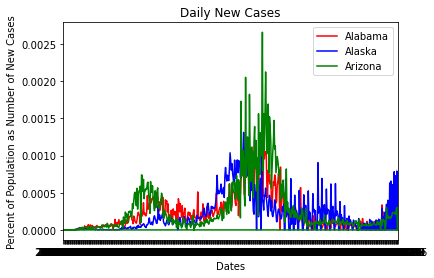

In [44]:
# List of all state df's
StateDF_list = [Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,
               Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,NewHampshire,NewJersey,NewMexico,NewYork,
               NorthCarolina,NorthDakota,Ohio,Oklahoma,Oregon,Pennsylvania,RhodeIsland,SouthCarolina,SouthDakota,Tennessee,Wisconsin,Wyoming]


In [ ]:
# ANOVA to test if any states are significantly different from the others
st.f_oneway(Alabama['%newCases'], Alaska['%newCases'], Arizona['%newCases'], Arkansas['%newCases'], California['%newCases'], Colorado['%newCases'],
              Connecticut['%newCases'], Delaware['%newCases'], Florida['%newCases'], Georgia['%newCases'], Hawaii['%newCases'], Idaho['%newCases'],
              Illinois['%newCases'], Indiana['%newCases'], Iowa['%newCases'], Kansas['%newCases'], Kentucky['%newCases'], Louisiana['%newCases'], 
              Maine['%newCases'], Maryland['%newCases'], Massachusetts['%newCases'], Michigan['%newCases'], Minnesota['%newCases'], Mississippi['%newCases'],
              Missouri['%newCases'], Montana['%newCases'], Nebraska['%newCases'], Nevada['%newCases'], NewHampshire['%newCases'], NewJersey['%newCases'],
              NewMexico['%newCases'], NewYork['%newCases'], NorthCarolina['%newCases'], NorthDakota['%newCases'], Ohio['%newCases'], Oklahoma['%newCases'],
              Oregon['%newCases'], Pennsylvania['%newCases'], RhodeIsland['%newCases'], SouthCarolina['%newCases'], SouthDakota['%newCases'], Tennessee['%newCases'],
              Texas['%newCases'], Utah['%newCases'], Vermont['%newCases'], Virginia['%newCases'], Washington['%newCases'], WestVirginia['%newCases'],
              Wisconsin['%newCases'], Wyoming['%newCases'])

In [ ]:
# for looped 1 sample t-test to isolate significant states for each variable of interest
NC_pvalues = []
ND_pvalues = []
C_pvalues = []
D_pvalues = []
LD_pvalues = []
for state in StateDF_list:
    t_test1 = st.ttest_1samp(state['%newCases'], covid_historic_df['%newCases'].mean())
    NC_pvalues.append(t_test1.pvalue)
    t_test2 = st.ttest_1samp(state['%newDeaths'], covid_historic_df['%newDeaths'].mean())
    ND_pvalues.append(t_test2.pvalue)
    t_test3 = st.ttest_1samp(state['%cases'], covid_historic_df['%cases'].mean())
    C_pvalues.append(t_test3.pvalue)
    t_test4 = st.ttest_1samp(state['%deaths'], covid_historic_df['%deaths'].mean())
    D_pvalues.append(t_test4.pvalue)
    t_test5 = st.ttest_1samp(state['stay at home length'], covid_historic_df['stay at home length'].mean())
    LD_pvalues.append(t_test5.pvalue)

State_list = ['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','Florida','Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana',
               'Maine','Maryland','Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','NewHampshire','NewJersey','NewMexico','NewYork',
               'NorthCarolina','NorthDakota','Ohio','Oklahoma','Oregon','Pennsylvania','RhodeIsland','SouthCarolina','SouthDakota','Tennessee','Wisconsin','Wyoming']

#Creating dataframes with each state's pvalues and filtering out values less than 0.05
NCt_test_df = pd.DataFrame(data={'State': State_list,'pvalue': NC_pvalues})
NDt_test_df = pd.DataFrame(data={'State': State_list,'pvalue': ND_pvalues})
Ct_test_df = pd.DataFrame(data={'State': State_list,'pvalue': C_pvalues})
Dt_test_df = pd.DataFrame(data={'State': State_list,'pvalue': D_pvalues})
LDt_test_df = pd.DataFrame(data={'State': State_list,'pvalue': D_pvalues})

NCsignificant_df = NCt_test_df[NCt_test_df['pvalue'] < 0.05]
NDsignificant_df = NDt_test_df[NDt_test_df['pvalue'] < 0.05]
Csignificant_df = Ct_test_df[Ct_test_df['pvalue'] < 0.05]
Dsignificant_df = Dt_test_df[Dt_test_df['pvalue'] < 0.05]
LDsignificant_df = LDt_test_df[LDt_test_df['pvalue'] < 0.05]

#Sorting to make easier to decipher
NCsignificant_df = NCsignificant_df.sort_values(by=['pvalue'])
NDsignificant_df = NDsignificant_df.sort_values(by=['pvalue'])
Csignificant_df = Csignificant_df.sort_values(by=['pvalue'])
Dsignificant_df = Dsignificant_df.sort_values(by=['pvalue'])
LDsignificant_df = LDsignificant_df.sort_values(by=['pvalue'])

In [ ]:
# Identifying most significantly different states
NCsignificant_df.head()
NDsignificant_df.head()
Csignificant_df.head()
Dsignificant_df.head()

In [ ]:
# Line plot showing number of new cases relative to population each day
plt.plot(Oregon['date'], Oregon['%newCases'], color='red', label='Oregon')
plt.plot(NewHampshire['date'], NewHampshire['%newCases'], color='blue', label='NewHampshire')
plt.plot(Hawaii['date'], Hawaii['%newCases'], color='green', label='Hawaii')
plt.plot(Maine['date'], Maine['%newCases'], color='yellow', label='Maine')
plt.plot(Maryland['date'], Maryland['%newCases'], color='purple', label='Maryland')

plt.plot(NorthDakota['date'], NorthDakota['%newCases'], color='pink', label='NorthDakota')

plt.legend()
plt.title('Daily New Cases as Percent of Total Population')
plt.xlabel('Dates')
plt.ylabel('Percent of Population as Number of New Cases')
plt.xlim(0,553)
plt.ylim(0,0.0040)

In [ ]:
# Line plot showing number of deaths relative to population each day
plt.plot(Oregon['date'], Oregon['%newDeaths'], color='red', label='Oregon')
plt.plot(NewHampshire['date'], NewHampshire['%newDeaths'], color='blue', label='NewHampshire')
plt.plot(Hawaii['date'], Hawaii['%newDeaths'], color='green', label='Hawaii')
plt.plot(Maine['date'], Maine['%newDeaths'], color='yellow', label='Maine')
plt.plot(Maryland['date'], Maryland['%newDeaths'], color='purple', label='Maryland')
plt.plot(Alaska['date'], Alaska['%newDeaths'], color='Orange', label='Alaska')
plt.plot(NorthDakota['date'], NorthDakota['%newDeaths'], color='pink', label='NorthDakota')

plt.legend()
plt.title('Daily New Deaths as Percent of Total Population')
plt.xlabel('Dates')
plt.ylabel('Percent of Population as Number of New Deaths')
plt.xlim(0,553)
plt.ylim(0,0.00006)

In [ ]:
lockdown_df
LD_pvalues = []
for state in lockdown_df['state']:
    t_test5 = st.ttest_1samp(lockdown_df['stay at home length'], lockdown_df['stay at home length'].mean())
    LD_pvalues.append(t_test5.pvalue)